In [1]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img

## Create the report with Parkinson volatility estimator 


### Create function for parkinson estimator:

In [6]:
def create_dataframe_high_low(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_low'] = hist['Low']
        df[security + '_high'] = hist['High']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_park_volatility(df_high_low, list_securities, window):
    '''
    input
    df = pandas dataframe with columns named: "security_low" and "security_high" (e.g. SSO_low SSO_high)
    list_securities = list of securities name
    window = int, number of days the index has to consider

    output
    df_output = pandas dataframe with securities as columns and parkinson volat estimator as rows


    dict_security_park_indx = dictionary: keys = securities,
                                          values = np.array with the index for each day; it has n - window elements
    '''

    dict_security_park_indx = {}

    k = np.sqrt(1/(4*window*np.log(2)))
    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_high_low) - window):
            for j in range(window):
                #creating array where storing the log((High_price/Low_price)^2)
                array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_high_low[security + '_high'][i+j] / df_high_low[security + '_low'][i+j])**2))
                # len(array_day_value) = window
            square_sum_value = np.sqrt(np.sum(array_day_value))
            array_value = np.append(array_value, k*square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,

def index_df(df_output, data):
    #just add the index to the dataframe
    
    data.drop(data.tail(window).index, inplace=True) # drop last n rows

    return df_output.set_index(data.index)

## Report

In [7]:
#['VTI', 'VGLT', 'VGIT', 'VPU', 'IAU'], 
#['UPRO', 'TMF', 'TYD', 'UTSL'],
#['SSO', 'UBT', 'UST', 'UPW', 'UGL']}
list_securities = ['SSO', 'UBT', 'UST', 'UPW', 'UGL']
window = 30 #days
title = 'x3 leverage pakingson volatility with utilities'

unique_name = 'park_estimator'
for i in list_securities:
    unique_name += '_' + i
    
data_h_l = create_dataframe_high_low(list_securities)

df_volat = compute_park_volatility(data_h_l, list_securities, window)
#display(df_volat)
data = hep.create_dataframe(list_securities)
data.dropna(inplace = True)
#data.drop(data.tail(window).index, inplace=True) # drop last n rows
#print(len(data))
df_volat = index_df(df_volat, data)

#display(data,df_volat)

df_weighted = hep.df_wheighted(df_volat)

data_r = data.div(data.shift(1))-1

data_earnings = hep.df_earnings(df_weighted, data_r)
data_earnings.dropna(inplace = True)

data_earnings = data_earnings[-1834:] #1834 len of the no leverage portfolio
display(data_earnings)

,SSO,UBT,UST,UPW,UGL,Tot
2014-11-13,0.000253,0.000941,0.000300,-0.006485,0.000460,-0.004532
2014-11-14,0.000130,0.001787,0.000426,-0.002252,0.012824,0.012914
2014-11-17,0.000177,-0.000970,-0.000243,0.005689,-0.001233,0.003420
2014-11-18,0.002614,0.001039,0.000205,0.003513,0.004284,0.011653
2014-11-19,-0.000745,-0.001963,-0.000717,-0.000995,-0.006406,-0.010827
...,...,...,...,...,...,...
2022-02-18,-0.002242,0.005181,0.001382,-0.001181,-0.000340,0.002800
2022-02-22,-0.004444,0.000897,-0.000088,-0.001181,0.000437,-0.004380
2022-02-23,-0.007949,-0.005906,-0.001175,-0.006758,0.001896,-0.019892
2022-02-24,0.006503,0.000137,0.000470,0.005110,-0.002301,0.009920


#### Table of returns

In [24]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

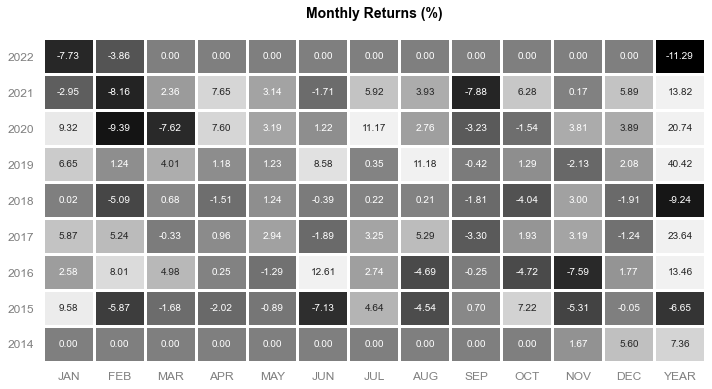

In [25]:
fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

#### Distributions of returns

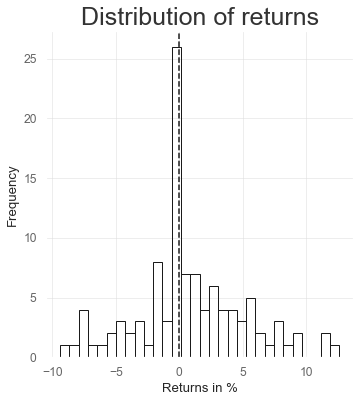

In [26]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics

In [27]:
statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
#statistics.to_csv('./data/temp/statistics_all_weather' + unique_name + '.csv')

statistics

,index,value
0,Annualised return,0.123382
1,Annualised volatility,0.179486
2,Sharpe ratio,0.687965
3,Sortino ratio,0.956058
4,Adjusted sortino,0.676035
5,Skew,-0.454254
6,Kurtosis,17.046778
7,Max drawdown,-0.320668
8,GPR,0.136130
9,Calmar ratio,0.352799


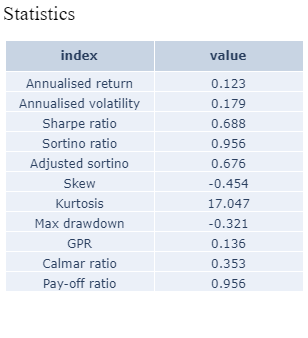

In [28]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')


#### Drawdown and underwater plots:

In [29]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

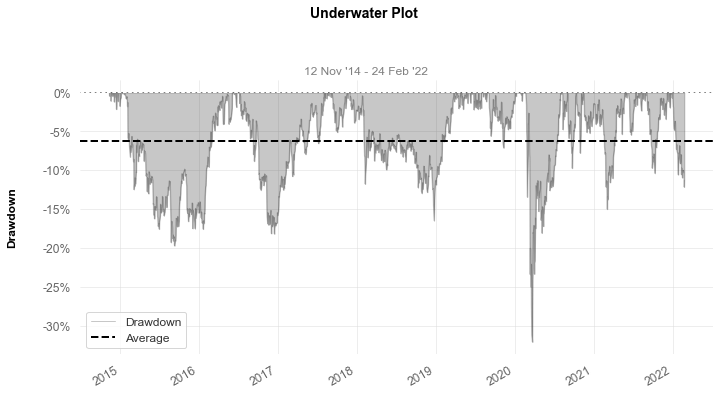

In [30]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

## Combine the plots and create a figure

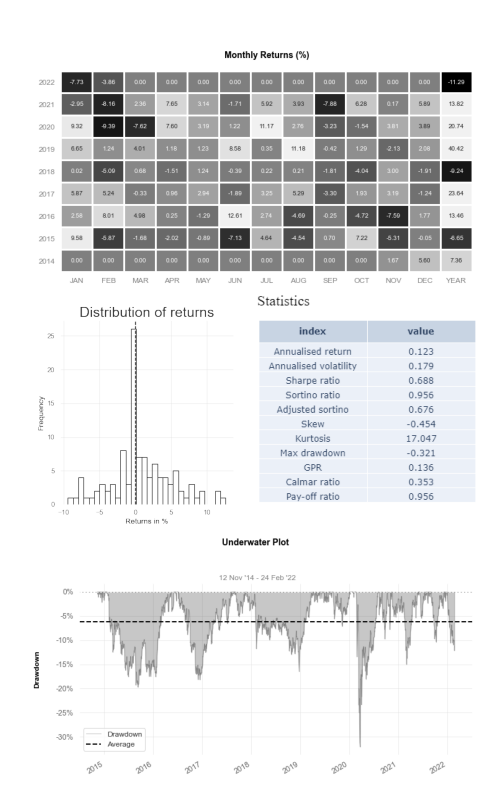

In [31]:
fig = plt.figure(figsize=(8, 13.55))

gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)

ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'w') #add the correct leverage

plt.savefig('../reports/report' + unique_name + '.png', dpi = 1200)

In [67]:
dictionary_util =  {'Utilities instead commodities' : ['VTI', 'VGLT', 'VGIT', 'VPU', 'IAU'], 
                    'Utilities instead commodities x3 leverage' : ['UPRO', 'TMF', 'TYD', 'UTSL'],
                    'Utilities instead commodities x2 leverage' : ['SSO', 'UBT', 'UST', 'UPW', 'UGL']}

dict_df = {}
for name in dictionary_util:
    list_securities = dictionary_util[name]
    print(list_securities)
    data_h_l = create_dataframe_high_low(list_securities)
    df_volat = compute_park_volatility(data_h_l, list_securities, window)
    data = hep.create_dataframe(list_securities)
    data.dropna(inplace = True)
    df_volat = index_df(df_volat, data)
    df_weighted = hep.df_wheighted(df_volat)
    data_r = data.div(data.shift(1))-1
    data_earnings = hep.df_earnings(df_weighted, data_r)
    data_earnings.dropna(inplace = True)
    data_earnings = data_earnings[-1834:] #1834 len of the no leverage portfolio
    #display(data_earnings)
    dict_df[name] = data_earnings

['VTI', 'VGLT', 'VGIT', 'VPU', 'IAU']
['UPRO', 'TMF', 'TYD', 'UTSL']
['SSO', 'UBT', 'UST', 'UPW', 'UGL']


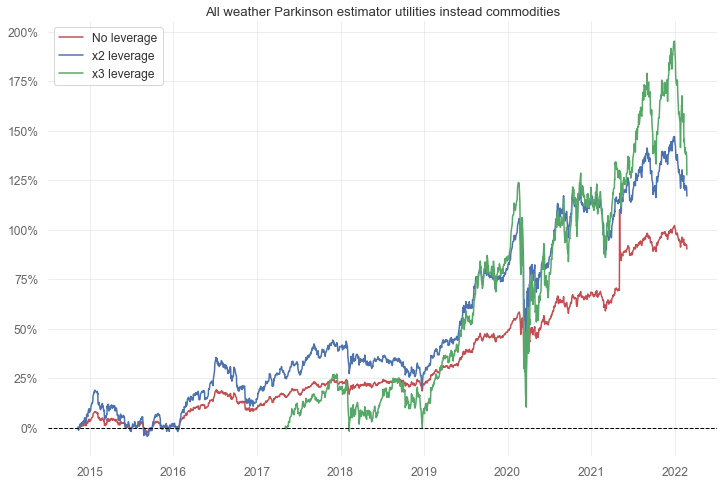

In [71]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('All weather Parkinson estimator utilities instead commodities')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(dict_df['Utilities instead commodities']['Tot']), lw=1.5, label='No leverage', color='r', alpha=1)
ax.plot(compsum(dict_df['Utilities instead commodities x2 leverage']['Tot']), lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(compsum(dict_df['Utilities instead commodities x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()

plt.savefig('../img/all_weather_parkinson_compare_leverage_utilities')